In [121]:
import numpy as np
import pandas as pd
import re
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
train_data = pd.read_csv('/content/drive/MyDrive/kaggle/train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/kaggle/train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [124]:
PassengerId = test_data['PassengerId']

In [125]:
full_data = [train_data, test_data]

train_data['Name_length'] = train_data['Name'].apply(len)
test_data['Name_length'] = test_data['Name'].apply(len)

y = lambda x: 0 if type(x) == float else 1

train_data['Has_Cabin'] = train_data['Cabin'].apply(y)
test_data['Has_Cabin'] = test_data['Cabin'].apply(y)

type(train_data['Cabin'][0])

float

In [126]:
for dataset in full_data:
  dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

for dataset in full_data:
  dataset['IsAlone'] = 0
  dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1

for dataset in full_data:
  dataset['Embarked'] = dataset['Embarked'].fillna('S')

for dataset in full_data:
  dataset['Fare'] = dataset['Fare'].fillna(train_data['Fare'].median())

train_data['CategoricaalFare'] = pd.qcut(train_data['Fare'], 4)

for dataset in full_data:
  age_avg = dataset['Age'].mean()
  age_std = dataset['Age'].std()
  age_null_count = dataset['Age'].isnull().sum()
  age_null_rnd_lst = np.random.randint(
      age_avg - age_std, age_avg + age_std, size=age_null_count
  )
  dataset['Age'][np.isnan(dataset['Age'])] = age_null_rnd_lst
  dataset['Age'] = dataset['Age'].astype(int)

train_data['CategoricalAge'] = pd.cut(train_data['Age'], 5)

In [127]:
def get_title(name):
  title_search = re.search('([A-Za-z]+)\.', name)
  if title_search:
    return title_search.group(1)
  return ""

for dataset in full_data:
  dataset['Title'] = dataset['Name'].apply(get_title)

for dataset in full_data:
  dataset['Title'] = dataset['Title'].replace(
      ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 
       'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
       'Rare')
  dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
  dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

for dataset in full_data:
  dataset['Sex'] = dataset['Sex'].map(
      {'female': 0, 'male': 1}
  ).astype(int)

  title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
  dataset['Title'] = dataset['Title'].map(title_mapping)
  dataset['Title'] = dataset['Title'].fillna(0)
  dataset['Embarked'] = dataset['Embarked'].map(
      {'S': 0, 'C': 1, 'Q': 2}
  ).astype(int)
  dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
  dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
  dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
  dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
  dataset['Fare'] = dataset['Fare'].astype(int)
  dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
  dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
  dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
  dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
  dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

In [128]:
drop_elements = ['PassengerId', 'Name', 'Ticket', 'Cabin', 'SibSp']
train_data = train_data.drop(drop_elements, axis=1)
train_data = train_data.drop(['CategoricalAge', 'CategoricaalFare'], axis=1)
test_data = test_data.drop(drop_elements, axis=1)

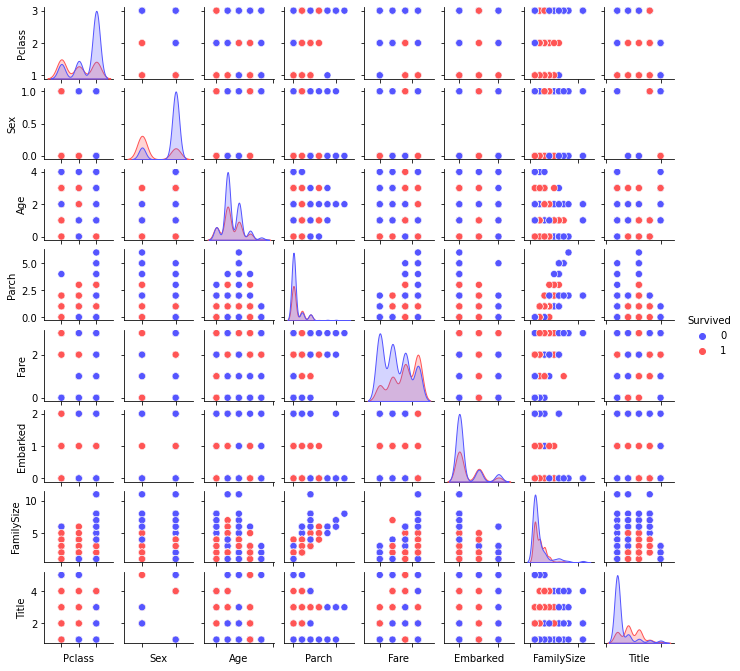

In [129]:
g = sns.pairplot(train_data[[u'Survived', u'Pclass', u'Sex', u'Age', u'Parch', u'Fare', u'Embarked',
       u'FamilySize', u'Title']], hue='Survived', palette = 'seismic',size=1.2,diag_kind = 'kde',diag_kws=dict(shade=True),plot_kws=dict(s=50) )
g.set(xticklabels=[])

In [130]:
train_data.shape, test_data.shape

((891, 12), (891, 12))

In [131]:
ntrain = train_data.shape[0]
ntest = test_data.shape[0]
SEED = 0
NFOLDS = 5
kf = KFold(n_splits=NFOLDS, random_state=SEED, shuffle=True)

class SklearnHelper(object):
  def __init__(self, clf, seed=0, params=None):
    params['random_state'] = seed
    self.clf = clf(**params)

  def train(self, x_train, y_train):
    self.clf.fit(x_train, y_train)

  def predict(self, x):
    return self.clf.predict(x)

  def fit(self, x, y):
    return self.clf.fit(x, y)

  def feature_importances(self, x, y):
    print(self.clf.fit(x, y).feature_importances_)

In [132]:
def get_oof(clf, x_train, y_train, x_test):
  oof_train = np.zeros((ntrain,))
  oof_test = np.zeros((ntest,))
  oof_test_skf = np.empty((NFOLDS, ntest))

  for i, (train_index, test_index) in enumerate(kf.split(x_train)):
    x_tr = x_train[train_index]
    y_tr = y_train[train_index]
    x_te = x_train[test_index]

    clf.train(x_tr, y_tr)

    oof_train[test_index] = clf.predict(x_te)
    oof_test_skf[i, :] = clf.predict(x_test)

  oof_test[:] = oof_test_skf.mean(axis=0)
  return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [133]:
rf_params = {
  'n_jobs': -1,
  'n_estimators': 500,
  'warm_start': True,
  'max_depth': 6,
  'min_samples_leaf': 2,
  'max_features': 'sqrt',
  'verbose': 0
}

et_params = {
    'n_jobs': -1,
    'n_estimators': 500,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

ada_params = {
    'n_estimators': 500,
    'learning_rate': 0.75
}

gb_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

svc_params = {
    'kernel': 'linear',
    'C': 0.025
}

In [134]:
rf = SklearnHelper(clf=RandomForestClassifier,seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier,seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier,seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier,seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC,seed=SEED, params=svc_params)

In [135]:
y_train = train_data['Survived'].ravel()
train_data = train_data.drop(['Survived'], axis=1)
test_data = test_data.drop(['Survived'], axis=1)
x_train = train_data.values
x_test = test_data.values

In [138]:
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test)
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test)
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test)
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test)
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test)

In [139]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

[0.1133227  0.24052479 0.03665244 0.01908901 0.04803415 0.02170608
 0.11227797 0.06615733 0.06904623 0.01131002 0.26187926]
[0.11913769 0.37740584 0.03215012 0.01739882 0.05499741 0.02760596
 0.04600384 0.08474715 0.04439732 0.02122928 0.17492658]
[0.032 0.014 0.018 0.064 0.038 0.008 0.692 0.014 0.052 0.    0.068]
[0.08715325 0.01034173 0.05157362 0.01171762 0.05277617 0.02517075
 0.17481435 0.03846017 0.11187508 0.00522293 0.43089434]
